# IMPORT NECESSARY PACKAGES

In [4]:
# If these packages are missing install them from requirements.txt file
# Make sure to use TF 1.x and Keras 2.2.5
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import tensorflow as tf
print(tf.__version__) #1.15.0
import keras
print(keras.__version__) # 2.2.5
import random
import matplotlib.pyplot as plt

1.15.0
2.2.5


Using TensorFlow backend.


# BUILDING THE MODEL


In [5]:
# Change the current working directory into the root folder
os.chdir('../')
# Defined root dir at the current directory
ROOT_DIR = './'
# Location of the date.
# This folder should contain two folders "train" and "val"
# "train" for the training set and "val" for the validation set
# Each of these folders should contain annotations in them
DATA_DIR = './assets/datasets/fruits'
# Logs and trained model saved here
DEFAULT_LOGS_DIR = './assets/logs'

In [6]:
# To find local version of the library
sys.path.append("./mrcnn")

# Local libraries within "mrcnn" folder
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [7]:
# Pre-trained weights - On COCO datasetr.
if os.path.exists("./assets/mask_rcnn_coco.h5"):
    #check if the pre-trained weights exists on assets folder
    print("Weights already exists in assets folder.Skipping download.")
    pass
else:
    # if not download from Mask RCNN GitHub repo
    !wget -P ./assets https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

# Assign the weights to a variable
COCO_WEIGHTS_PATH = "./assets/mask_rcnn_coco.h5"

Weights already exists in assets folder.Skipping download.


In [8]:
class FruitsConfig(Config):
    """Configuration for training.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "fruit"


    # 00:02.0 VGA compatible controller: 
    # Intel Corporation UHD Graphics 620 (Whiskey Lake) (rev 02)
    IMAGES_PER_GPU =   1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + baloon

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.90

In [9]:
############################################################
#  Dataset
############################################################

class FruitsDataset(utils.Dataset):

    def load_fruit(self, dataset_dir, subset):
        """Load a subset of the Fruits dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("fruit", 1, "fruit")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations = json.load(open(os.path.join(dataset_dir, "via_project_fruits.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "fruit",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a fruit dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "fruit":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "fruit":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)       

# TRAINING THE MODEL

In [10]:
def train(model,epochs):
    """Train the model."""
    # Training dataset.
    dataset_train = FruitsDataset()
    dataset_train.load_fruit(DATA_DIR, "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = FruitsDataset()
    dataset_val.load_fruit(DATA_DIR, "val")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=epochs,
                layers='heads') 

In [8]:
print('Training')

config = FruitsConfig()

model = modellib.MaskRCNN(mode="training", config=config,
                      model_dir=DEFAULT_LOGS_DIR)

weights_path = COCO_WEIGHTS_PATH

#COCO_WEIGHTS_PATH = '../../../mask_rcnn_coco.h5'

# Find last trained weights
# weights_path = model.find_last()[1]


model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
epochs = 150

train(model, epochs)

Training






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead






Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: ./assets/logs/fruit20201028T1139/mask_rcnn_fruit_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3

/home/kiprono/Documents/STELLENBOSCH UNIVERSITY/Masters by Research/Mask_R-CNN-Fruits-Detection/Model/venv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/kiprono/Documents/STELLENBOSCH UNIVERSITY/Masters by Research/Mask_R-CNN-Fruits-Detection/Model/venv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/kiprono/Documents/STELLENBOSCH UNIVERSITY/Masters by Research/Mask_R-CNN-Fruits-Detection/Model/venv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse In

/home/kiprono/Documents/STELLENBOSCH UNIVERSITY/Masters by Research/Mask_R-CNN-Fruits-Detection/Model/venv/lib/python3.7/site-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/150
  1/100 [..............................] - ETA: 1:52:01 - loss: 5.5300 - rpn_class_loss: 0.7573 - rpn_bbox_loss: 1.1243 - mrcnn_class_loss: 1.0790 - mrcnn_bbox_loss: 1.5053 - mrcnn_mask_loss: 1.0642

Process ForkPoolWorker-4:
Process ForkPoolWorker-13:
Process ForkPoolWorker-2:
Process ForkPoolWorker-5:
Process ForkPoolWorker-15:
Process ForkPoolWorker-14:
Process ForkPoolWorker-3:
Process ForkPoolWorker-8:
Process ForkPoolWorker-16:
Process ForkPoolWorker-10:
Process ForkPoolWorker-9:
Process ForkPoolWorker-1:
Process ForkPoolWorker-7:
Process ForkPoolWorker-6:
Process ForkPoolWorker-11:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
  

## SAVING MODEL STATS INTO JSON


In [11]:
try: #open JSON file containing the model training stats if it is available
    history = json.load(open('./assets/history/train_history.json'))
except FileNotFoundError as s: #if not available try the following block
    try: # If the model was just trained above read the stats from model
        history = model.keras_model.history.history
    except: # If the model has not been trained, go ahead and train it.
        print('Training')
        config = FruitsConfig()
        model = modellib.MaskRCNN(mode="training", config=config,
                              model_dir=DEFAULT_LOGS_DIR)
        weights_path = COCO_WEIGHTS_PATH

        #COCO_WEIGHTS_PATH = '../../../mask_rcnn_coco.h5'

        # Find last trained weights
        # weights_path = model.find_last()[1]


        model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
        epochs = 5
        train(model, epochs)

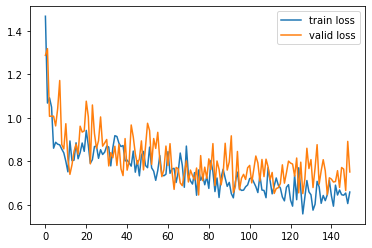

In [12]:
# Plot model history stats
epochs = range(len(history["val_loss"]))
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="valid loss")
plt.legend()

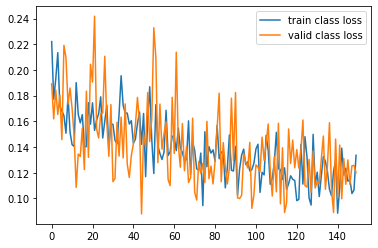

In [13]:
plt.plot(epochs, history['mrcnn_class_loss'], label="train class loss")
plt.plot(epochs, history['val_mrcnn_class_loss'], label="valid class loss")
plt.legend()

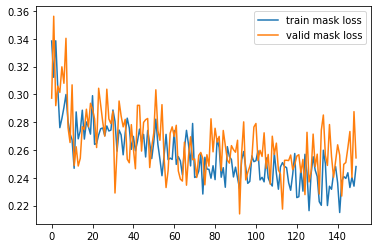

In [14]:
plt.plot(epochs, history['mrcnn_mask_loss'], label="train mask loss")
plt.plot(epochs, history['val_mrcnn_mask_loss'], label="valid mask loss")
plt.legend()

 # TESTING THE MODEL ON SAMPLE DATA (VISUALIZATION)

In [15]:
# Local path to trained model file
MODEL_PATH = "./assets/logs/fruit20200802T0017/mask_rcnn_fruit_0477.h5"
# If model not available use the COCO pre-trained weights
if not os.path.exists(MODEL_PATH): 
    MODEL_PATH = "./assets/mask_rcnn_coco.h5"
    # If COCO weights not available download
    if not os.path.exists(MODEL_PATH):
        !wget -P ./assets https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
        MODEL_PATH = "./assets/mask_rcnn_coco.h5"


In [16]:
config = FruitsConfig()
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir="./trained", config=config)

# Load weights trained on MS-COCO or the saved model
model.load_weights(MODEL_PATH, by_name=True)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.






Re-starting from epoch 477


In [17]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'fruit']

Processing 1 images
image                    shape: (500, 500, 3)         min:    0.00000  max:  231.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  102.30000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


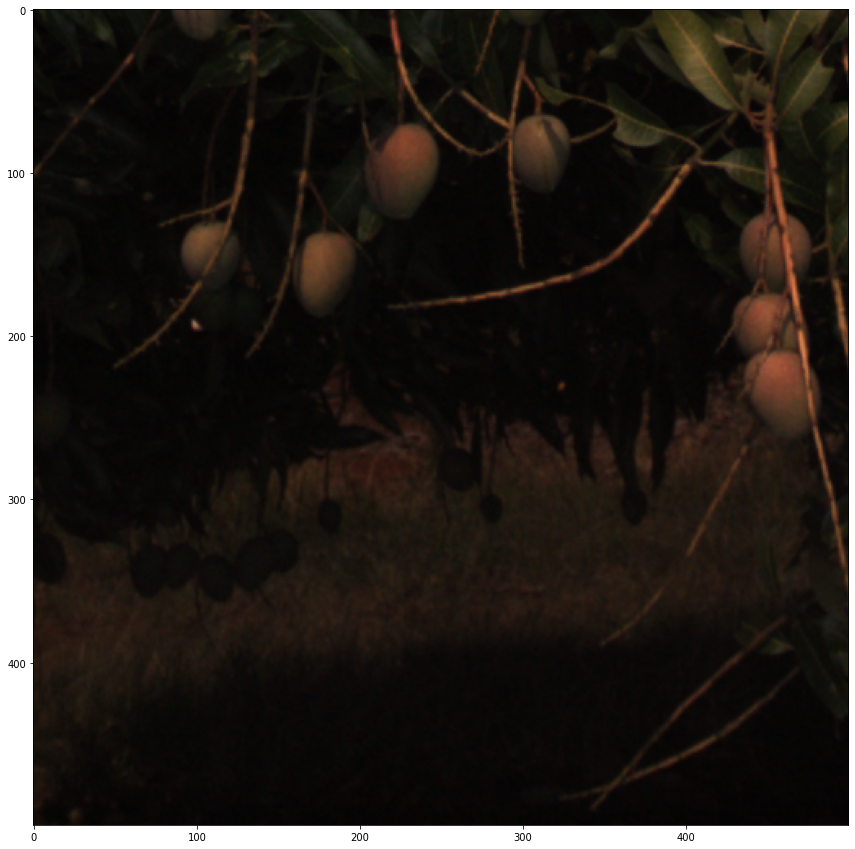

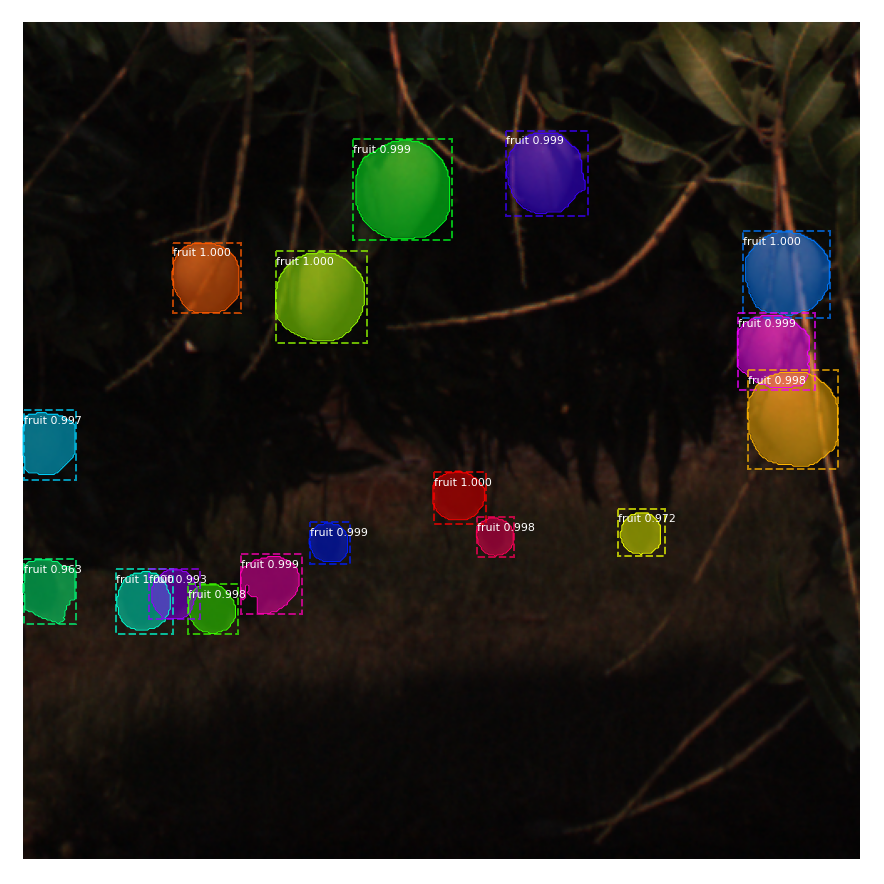

In [18]:
# Load a random image from the images folder
file_names = [item for item in os.listdir(os.path.join(DATA_DIR,"val")) \
             if not item.startswith("via")]
file_ = random.choice(file_names)

# read image using scikit image library
image = skimage.io.imread(os.path.join(DATA_DIR,"val",file_))
# mrcnn_checkpoint = model.run_graph([image], [
# ("detections", model.keras_model.get_layer("mrcnn_detection").output)])
# # display RGB image
plt.figure(figsize=(15,15))
plt.imshow(image)

# Run detection'
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
display_ = visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])


## RUN DETECTION ON THE TRAIN SET AND SAVE THE OUTPUT MASKS

In [19]:
# segmentation masks that have been already generated
# Important to enable pause and continue of the execution
# without having to start all over again
done = os.listdir("./output/train_masks_pred/")

## loop through all train images and save masks
# List of train images in which we are to run detection on
files = os.listdir(DATA_DIR+"/train");
for index,file_ in enumerate(files):
    file1, _ = os.path.splitext(file_)
    f = "{}_mask2.npy".format(file1)
    if f in done or "via" in f: #if mask has already been generated, skip
        #skip the annotations file as well
        print(index,f,"is done.Passing.")
        continue
    else:
        print(index,file_)
        #Load image
        image = skimage.io.imread(os.path.join(DATA_DIR+"/train", file_))
        # Run detection
        results = model.detect([image], verbose=1)
        # Results of interest. The segmentation masks
        r = results[0]
        file_,_ = os.path.splitext(file_)
        # Segmentation mask will be saved as a numpy array with the following name
        filename = "./output/train_masks_pred/{}_mask2.npy".format(file_)
        masks = []
        #loop through all the detections.
        for i in range(len(r["scores"])):
            # saving: filename, mask and confidence scores.
            a = {
                "filename":None,
                "mask": None,
                "confidence": None
            }
            a["filename"] = file_
            a["mask"] = r["mask_scores"][:,:,i]
            a["confidence"] = r["scores"][i]
            masks.append(a)
        print(filename)
        masks = np.array(masks)
        np.save(filename,masks)
        
        

0 via_project_fruits_mask2.npy is done.Passing.
1 20130320T004547.804094.Cam6_12_mask2.npy is done.Passing.
2 20130320T004620.376266.Cam6_41_mask2.npy is done.Passing.
3 20151124T024524.796253_i1870j760_mask2.npy is done.Passing.
4 _MG_8080_08_mask2.npy is done.Passing.


## RUN DETECTION ON THE TEST SET AND SAVE THE OUTPUT MASKS

In [20]:
## loop through all test images and save masks
# The rest of the code follows the same explanation as of the train set
done = os.listdir("./output/test_masks_pred")
files = os.listdir(DATA_DIR+"/val");
for index,file_ in enumerate(files):
    file1 = file_[:-4]
    f = "{}_mask2.npy".format(file1)
    if f in done or "via" in f:
        print(index,f,"is done.Passing.")
        continue
    else:
        image = skimage.io.imread(os.path.join(DATA_DIR+"/val", file_))
        results = model.detect([image], verbose=1)
        r = results[0]
        file_,_ = os.path.splitext(file_)
        filename = "./output/test_masks_pred/{}_mask2.npy".format(file_)
        masks = []
        for i in range(len(r["scores"])):
            a = {
                "filename":None,
                "mask": None,
                "confidence": None
            }
            a["filename"] = file_
            a["mask"] = r["mask_scores"][:,:,i]
            a["confidence"] = r["scores"][i]
            masks.append(a)

        masks = np.array(masks)
        np.save(filename,masks)

0 via_project_fruits._mask2.npy is done.Passing.
1 20130320T004849.903118.Cam6_43_mask2.npy is done.Passing.
2 _MG_8993_24_mask2.npy is done.Passing.
3 20151124T044642.641468_i2238j1002_mask2.npy is done.Passing.
